# Classification of programming languages
*- Akash Singh Chouhan*

## Abstract
The objective of this notebook is to build a classification model which can predict the programming language given a code snippet as the input. For this purpose, three different algorithms will be used to build three different models and the model with highest accuracy on the test data would be considered as the winner. The three algorithms selected for this task are - *Random Forest Classifier* , *Logistic Regression Classifier*, and *Support Vector Machine*. 

### Import all the required libraries
Please make sure that the following libraries are installed before running this notebook - *pandas*, *numpy*, *scikit-learn* and *matplotlib*.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_fscore_support as metrics_data

## Read the data

In [2]:
# Read the data to be used for training and testing of the model.
df = pd.read_csv('data.csv')

df.head()

,language,proj_id,file_id,file_body
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...


## Data observation and cleaning

Lets check the amount of file_body having less than 10 characters. The purpose of doing so is to see the amount of unuseful information some of the the file_body may have.

In [3]:

for i in range(df.shape[0]):
    if len(str(df.iloc[i]['file_body']))<10:
        print(df.iloc[i]['file_body'])

x.y()

5

"abcd"

Infinity

1320

1320

1320

["DBAC"]

3

nan
2.3
2.3

2.3

abcd

int a;

int j;

> env

a %*% b

diag(3)

g > h

a > g

alarm()

&s{}

new(s)

x := 3

x

EvenQ[8]

nan
5
6

$ math

tsitest

8664

f[1,2]

f[]

x=Null;

x===Null

0^0

f[]

Gamma[x]

a = 0

IsNaN(x)

nan
lcm(m,n)

eye(3)

eye(2,3)

A'

gamma(x)

det(A)

INF

xpbombs

pi

 clock

life

XYZ

\ ->

\

->

"ha" x 5

nan
&foo;

foo;



#### Observation 1 -
From the output above, it can be observed that some of the file_body carries some irrelevant information.

### Data distribution
Now, lets plot a graph to see the distribution of samples per class.

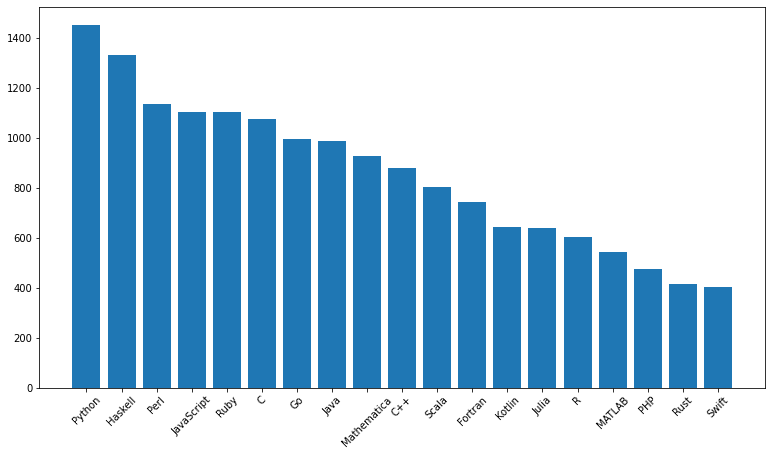

In [4]:
# Create a function to plot dictionary as graph
def plot_distribution(lang_lst):
    
    # Create a dictionary with language as Key and total number of samples per language as Value
    lang_count = dict(Counter(lang_lst).items())

    # Sort the dictionary in decreasing order
    lang_count = dict(sorted(lang_count.items(), key=lambda item: item[1], reverse = True))

    plt.figure(figsize=(13,7))
    plt.bar(*zip(*lang_count.items()))
    plt.xticks(rotation=45)
    plt.show()


# Plot the number of samples per languge 
plot_distribution(df['language'].to_list())

#### Observation 2 -  
On observing the graph it can be noticed that there is certain imbalance within the number of samples per class.


With regards to obervation 1 and 2, there is a certain step which can help in minimizing the negative effect of both these observations on the model. The step would be to first merge the file_body having same language and proj_id, and then filtering out the samples whose file_body has character length lower than 10. This would help in normalizing the distribution and getting rid of some data which is basically gibberish.

In [5]:
#drop the file_id column
df.drop('file_id', axis=1, inplace = True)

# Drop rows having any NA values in any columns
df.dropna(axis = 0, how = 'any' , inplace =True)

# Merge the file_body of the samples having same proj_id and language. Newline character is...
# ...used as separator between different file_body after they are merged.
df['file_body'] = df.groupby(['proj_id','language'])['file_body'].transform(lambda x: ' \n '.join(x))

# drop duplicate rows
df = df.drop_duplicates()

# Drop the rows still having less than 10 characters in the file_body
df = df[df['file_body'].map(len) > 10]
    
print("Number of samples in the dataset after merging rows : "+ str(df.shape[0]))

Number of samples in the dataset after merging rows : 9988


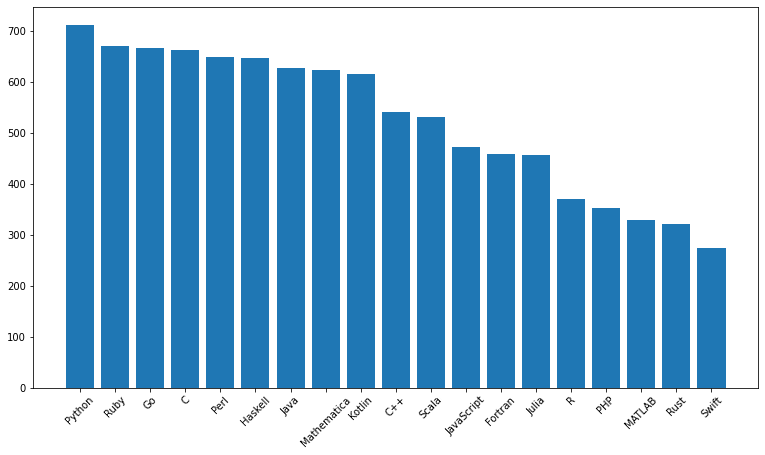

In [6]:
# Plot the number of samples per languge 
plot_distribution(df['language'].to_list())

It can noticed from the above graph that the distribution of samples per class has become more uniform compared to the previous graph.

### Split the data into train and test set

In [7]:
# drop proj_id as it is no longer needed
df = df[['file_body','language']]


# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df['file_body'], df['language'], test_size=0.25)


## Data preprocessing

Create a regex pattern to identify three categories of tokens i.e. Keywords/Variables, Operators and Tabs/Spaces/Braces. Numbers are common for all languages therfore it is better to not include them as tokens and they wont have any impact in differentiating languages.


### Tokenization

In [8]:

# Create a regex string to identify all tokens
pattern_breakdown = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])"""

# Create a TF-IDF vectorizer
vectorize_data = TfidfVectorizer(token_pattern = pattern_breakdown, max_features=5000 , min_df=3)

# Fit vectorizer on training data
vectorize_data.fit(X_train)

# generate tokens from training data
tokens = vectorize_data.get_feature_names()

print(tokens)

['\t', ' ', '!', '!!', '!!!', '!!.', '!$', '!&', '!*', '!-*-', '!-----------------------------------------------------------------------', '!</', '!=', '!==', '!===', '!\\', '"', '#', '#!', '#!/', '##', '###', '######', '#######', '########', '#-', '#.', '#::', '#<', '#=>', '#@', '#\\', '$', '$!', '$#', '$#$', '$$', '$.', '$/', '$=', '$@', '$_', '$_->', '$_\\', '%', '%#', '%$', '%%', '%%\\', '%*', '%+', '%-', '%.', '%.*', '%=', '&', '&#', '&$', '&&', '&&&', '&/@', '&:', '&=', '&@', "'", '(', ')', '*', '*$', '**', '***', '*.', '*/', '*=', '*_', '+', '+$', '++', '++$', '+-', '+.', '+/', '+:', '+:=', '+=', '+\\', '+_', ',', '-', '-#', '-$', '-%', '-*-', '--', '---', '----', '-----', '------', '----------', '------------', '--------------', '-----------------------', '------------------------------------------------------', '-------------------------------------------------------------------', '-->', '-.', '-=', '->', '->_', '.', '.$', '.*', '.+', '..', '..$', '..-', '...', '....', '.....'

c:\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Stop words removal
The ideal stop words in this insatnce would be the variable names and string literals in all programming languages. As they don't contribute in making distinction within the languagesmost of the time. But its also difficult to filter out such words for each language, therefore we try to take an easier path and simply remove all single alphabet characters and repetitive single characters. Examples: x, aa, bbbb etc.

In [9]:
# Create a funtion to remove stopwords.
def remove_stopwords(x):
    return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True).replace(r'\b[A-Za-z]\b', '', regex=True)

# create an instance of the FunctionTransformer using the remove_stopwords as parameter.
transform_data = FunctionTransformer(remove_stopwords)

## Model fitting 

Lets try few different models. Each model will follow the same pattern for building i.e. at first hyperparameters would be fine-tuned using GridSearchCV and then evaluation would be done. This would give a better idea about which algorithm works best for this use-case.

*Note -* As GridSearchCV is an computationally extensive algorithm, therefore only a limited number of parameters were used for fine-tuning. Using a large set of parameters for each algorithms might give different results than presented here.

### 1. Random Forest Classifier

In [10]:

# Initialize the classifier
clf = RandomForestClassifier(n_jobs=-1)

# Build a pipeline to preprocess data, vectorize data and ultimately train the model
model_pipe_rf = Pipeline([
    ('preprocessing', transform_data),
    ('vectorizer', vectorize_data),
    ('clf', clf)]
)


# create a dictionary of parameters to perform the grid search on
param_grid_rf = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_features': ['sqrt','log2'],
    'clf__min_samples_split': [2,3],
    'clf__n_estimators': [200,300]
}

# Initialize GridSearchCV with all the parameters
grid_search_rf = GridSearchCV(model_pipe_rf, param_grid = param_grid_rf, cv=3, n_jobs =-1, verbose=3)

# Start the training
grid_search_rf.fit(X_train, y_train)

# Evaluate the best performing model
print('Accuracy: '+ str(grid_search_rf.score(X_test, y_test)))

# Evaluate the Precision, Recall and Fscore
predicted = grid_search_rf.predict(X_test)

precision, recall, fscore, support = metrics_data(y_test, predicted)

print("Mean Fscore : " + str(np.mean(fscore)))

# Best set of parameters
print("The best set of parameters for Random forest is : ")
print(grid_search_rf.best_params_)



Fitting 3 folds for each of 16 candidates, totalling 48 fits
Accuracy: 0.9619543452142572
Mean Fscore : 0.9595005281115313
The best set of parameters for Random forest is : 
{'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 300}


### 2. Logistic Regression

In [11]:
# Initialize the classifier
clf_lr = LogisticRegression(max_iter = 500)

# Build a pipeline to preprocess data, vectorize data and ultimately train the model
model_pipe_lr = Pipeline([
    ('preprocessing', transform_data),
    ('vectorizer', vectorize_data),
    ('clf', clf_lr)]
)


# create a dictionary of parameters to perform the grid search on
param_grid_lr = {
    'clf__C':[0.01, 0.1, 1, 10],
    'clf__solver':['lbfgs','saga']
    }

# Initialize GridSearchCV with all the parameters
grid_search_lr = GridSearchCV(model_pipe_lr, param_grid = param_grid_lr, cv=3, n_jobs =-1, verbose=3)

# Start the training
grid_search_lr.fit(X_train, y_train)

# Evaluate the best performing model
print('Accuracy: '+ str(grid_search_lr.score(X_test, y_test)))

# Evaluate the Precision, Recall and Fscore
predicted = grid_search_lr.predict(X_test)

precision, recall, fscore, support = metrics_data(y_test, predicted)

print("Mean Fscore : " + str(np.mean(fscore)))

# Best set of parameters
print("The best set of parameters for Logistic regression is : ")
print(grid_search_lr.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Accuracy: 0.9459351221465759
Mean Fscore : 0.9423444949235533
The best set of parameters for Logistic regression is : 
{'clf__C': 10, 'clf__solver': 'lbfgs'}


### 3. Support Vector Machine

In [12]:
# Initialize the classifier
clf_svm = SVC()

# Build a pipeline to preprocess data, vectorize data and ultimately train the model
model_pipe_svm = Pipeline([
    ('preprocessing', transform_data),
    ('vectorizer', vectorize_data),
    ('clf', clf_svm)]
)


# create a dictionary of parameters to perform the grid search on
param_grid_svm = {
    'clf__kernel': ['linear','poly'],
    'clf__C':[0.1, 1, 10,100]
    
    }

# Initialize GridSearchCV with all the parameters
grid_search_svm = GridSearchCV(model_pipe_svm, param_grid = param_grid_svm, cv=3, n_jobs =-1, verbose=3)

# Start the training
grid_search_svm.fit(X_train, y_train)

# Evaluate the best performing model
print('Accuracy: '+ str(grid_search_svm.score(X_test, y_test)))

# Evaluate the Precision, Recall and Fscore
predicted = grid_search_svm.predict(X_test)

precision, recall, fscore, support = metrics_data(y_test, predicted)

print("Mean Fscore : " + str(np.mean(fscore)))

# Best set of parameters
print("The best set of parameters for SVM is : ")
print(grid_search_svm.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Accuracy: 0.9375250300360433
Mean Fscore : 0.9333235716109535
The best set of parameters for SVM is : 
{'clf__C': 10, 'clf__kernel': 'linear'}


### Result Analysis
The above results of each models shows that the *Random Forest Classifier* has the highest accuracy as well as the mean fscore among all three algorithms. Therefore, it can concluded that it is the best performing model in this instance with an accuracy of *96.19%* on test data.

## Fun time!
Lets makes some predictions with the RF model and test its real world robustness.

In [25]:
random_snippets = [
"import pandas as pd", 
    
"include <iostream>  \nint main() ",
    
"var = 5", 
    
""" 
<head>
  <title>Title of the document</title>
</head>
""",

"abcdfg"]

for itm in random_snippets:
    print(" ")
    print("Snippet below -")
    print(itm)
    print("Predicted language : " + str(grid_search_rf.predict(itm)[0]))
    print("*********************************")


 
Snippet below -
import pandas as pd
Predicted language : Python
*********************************
 
Snippet below -
include <iostream>  
int main() 
Predicted language : C++
*********************************
 
Snippet below -
var = 5
Predicted language : Swift
*********************************
 
Snippet below -
 
<head>
  <title>Title of the document</title>
</head>

Predicted language : Haskell
*********************************
 
Snippet below -
abcdfg
Predicted language : Mathematica
*********************************


The above result shows that the model performs quite humanly. It predicts correctly for the Python and C++ instance. Third instance could be confusing to any master programmer to predict as the given code could belong to multiple languages but, the models prediction of Swift is justified since var is a keyword in the language. Fourth test case is HTML but since it wasn't part of the trained classes of languages the model predicts it to be Haskell which might be due to Haskell training samples having any HTML code embedded into it. The last piece is simply some gibberish.

In [ ]:
clfs = [RandomForestClassifier(n_jobs=-1), LogisticRegression(max_iter = 500) ,SVC()]


